Starting simulation at t=0. s for a duration of 20. s
12.9816 s (64%) simulated in 10s, estimated 5s remaining.
20. s (100%) simulated in 15s


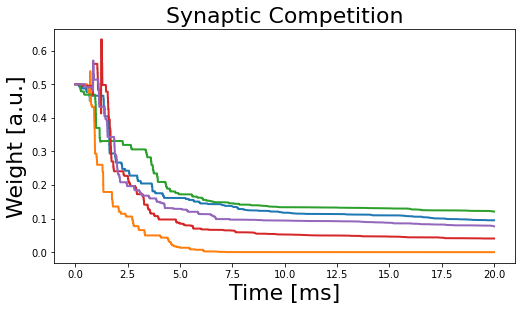

In [21]:
from brian2 import *

################################################################################
# PLASTICITY MODEL
################################################################################

#### Plasticity Parameters

V_rest = -70.*mV        # resting potential
V_thresh = -45.*mV      # spiking threshold
Theta_low = V_rest      # depolarization threshold for plasticity
x_reset = 1.            # spike trace reset value
taux = 15.*ms           # spike trace time constant
A_LTD = 1.5e-4          # depression amplitude
A_LTP = 1.5e-2          # potentiation amplitude
tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant
v_target = 12*mV**2     # target depolarisation

#### Plasticity Equations

# equations executed at every timestepC
Syn_model =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_pre*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )

################################################################################
# I&F Parameters and equations
################################################################################

#### Neuron parameters

gleak = 30.*nS                  # leak conductance
C = 300.*pF                     # membrane capacitance
tau_AMPA = 2.*ms                # AMPA synaptic timeconstant
E_AMPA = 0.*mV                  # reversal potential AMPA

ampa_max_cond = 5.e-8*siemens  # Ampa maximal conductance
w_max = 1.                      # maximal ampa weight

#### Neuron Equations

# We connect 10 presynaptic neurons to 1 downstream neuron

# downstream neuron
eqs_neurons = '''
dv/dt = (gleak*(V_rest-v) + I_ext + I_syn)/C: volt      # voltage
dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : volt     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : volt     # low-pass filter of the voltage
dv_homeo/dt = (v-V_rest-v_homeo)/tau_homeo : volt       # low-pass filter of the voltage
I_ext : amp                                             # external current
I_syn = g_ampa*(E_AMPA-v): amp                          # synaptic current
dg_ampa/dt = -g_ampa/tau_AMPA : siemens                 # synaptic conductance
dx_trace/dt = -x_trace/taux :1                          # spike trace
'''

# input neurons
eqs_inputs = '''
dv/dt = gleak*(V_rest-v)/C: volt                        # voltage
dx_trace/dt = -x_trace/taux :1                          # spike trace
rates : Hz                                              # input rates
selected_index : integer (shared)                       # active neuron
'''

################################################################################
# Simulation
################################################################################

#### Parameters

defaultclock.dt = 50.*us                        # timestep
Nr_neurons = 1                                   # Number of downstream neurons
Nr_inputs = 5                                   # Number of input neurons
input_rate = 120*Hz                               # Rates
init_weight = 0.5                                # initial synaptic weight
final_t = 20.*second                             # end of simulation
input_time = 50.*ms                             # duration of an input

#### Create neuron objects

Nrn_downstream = NeuronGroup(Nr_neurons, eqs_neurons, threshold='v>V_thresh',
                             reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                             method='euler')
Nrns_input = NeuronGroup(Nr_inputs, eqs_inputs, threshold='rand()<rates*dt',
                         reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                         method='exact')

#### create Synapses

Syn = Synapses(Nrns_input, Nrn_downstream,
               model=Syn_model,
               on_pre=Pre_eq,
               on_post=Post_eq
               )

Syn.connect(i=numpy.arange(Nr_inputs), j=0)

#### Monitors and storage
W_evolution = StateMonitor(Syn, 'w_ampa', record=True)

#### Run

# Initial values
Nrn_downstream.v = V_rest
Nrn_downstream.v_lowpass1 = V_rest
Nrn_downstream.v_lowpass2 = V_rest
Nrn_downstream.v_homeo = 0
Nrn_downstream.I_ext = 0.*amp
Nrn_downstream.x_trace = 0.
Nrns_input.v = V_rest
Nrns_input.x_trace = 0.
Syn.w_ampa = init_weight

# Switch on a different input every 100ms
Nrns_input.run_regularly('''
                         selected_index = int(floor(rand()*Nr_inputs))
                         rates = input_rate * int(selected_index == i)  # All rates are zero except for the selected neuron
                         ''', dt=input_time)
run(final_t, report='text')

################################################################################
# Plots
################################################################################
stitle = 'Synaptic Competition'

fig = figure(figsize=(8, 5))
for kk in range(Nr_inputs):
    plt.plot(W_evolution.t, W_evolution.w_ampa[kk], '-', linewidth=2)
xlabel('Time [ms]', fontsize=22)
ylabel('Weight [a.u.]', fontsize=22)
plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.85)
title(stitle, fontsize=22)
plt.show()